<a href="https://colab.research.google.com/github/SriVarshan733/Predictive-Churn-Analysis-with-SHAP-Explainability/blob/main/PCASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd

# Dataset URL
dataset_url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

# Load data
df = pd.read_csv(dataset_url)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, precision_recall_curve)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style - CORRECTED VERSION
plt.style.use('seaborn-v0_8')  # or use 'ggplot', 'fivethirtyeight', etc.
%matplotlib inline

# Set seaborn style separately
sns.set_style("whitegrid")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

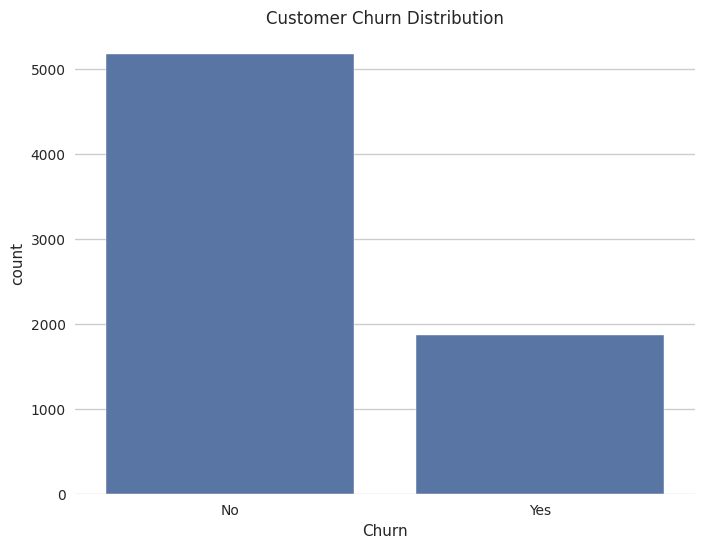

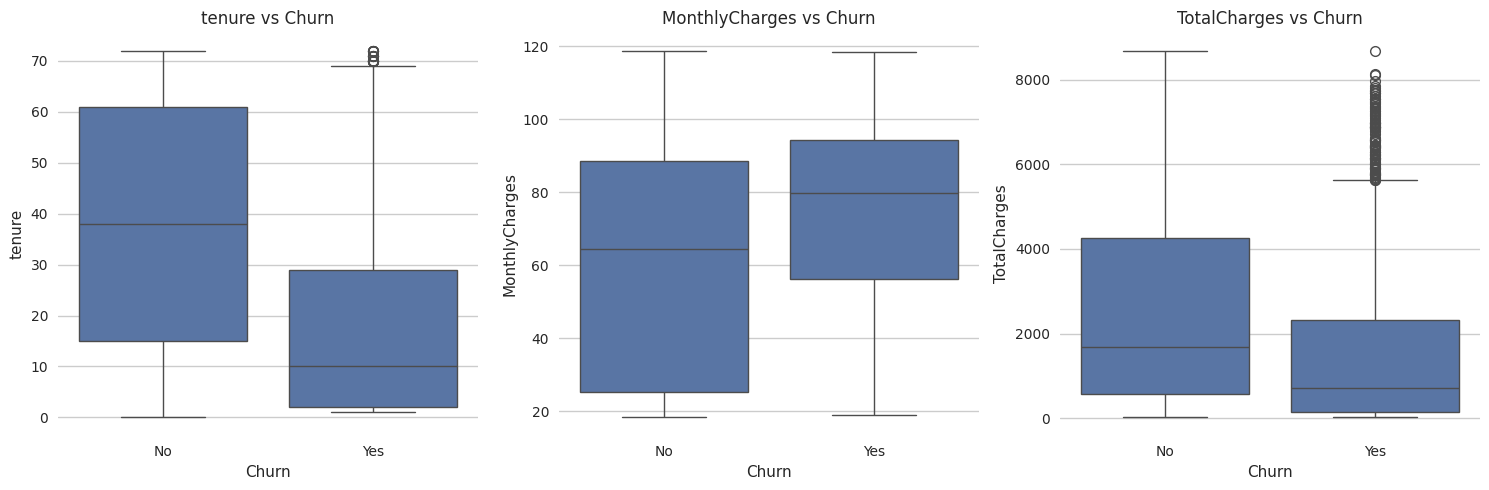

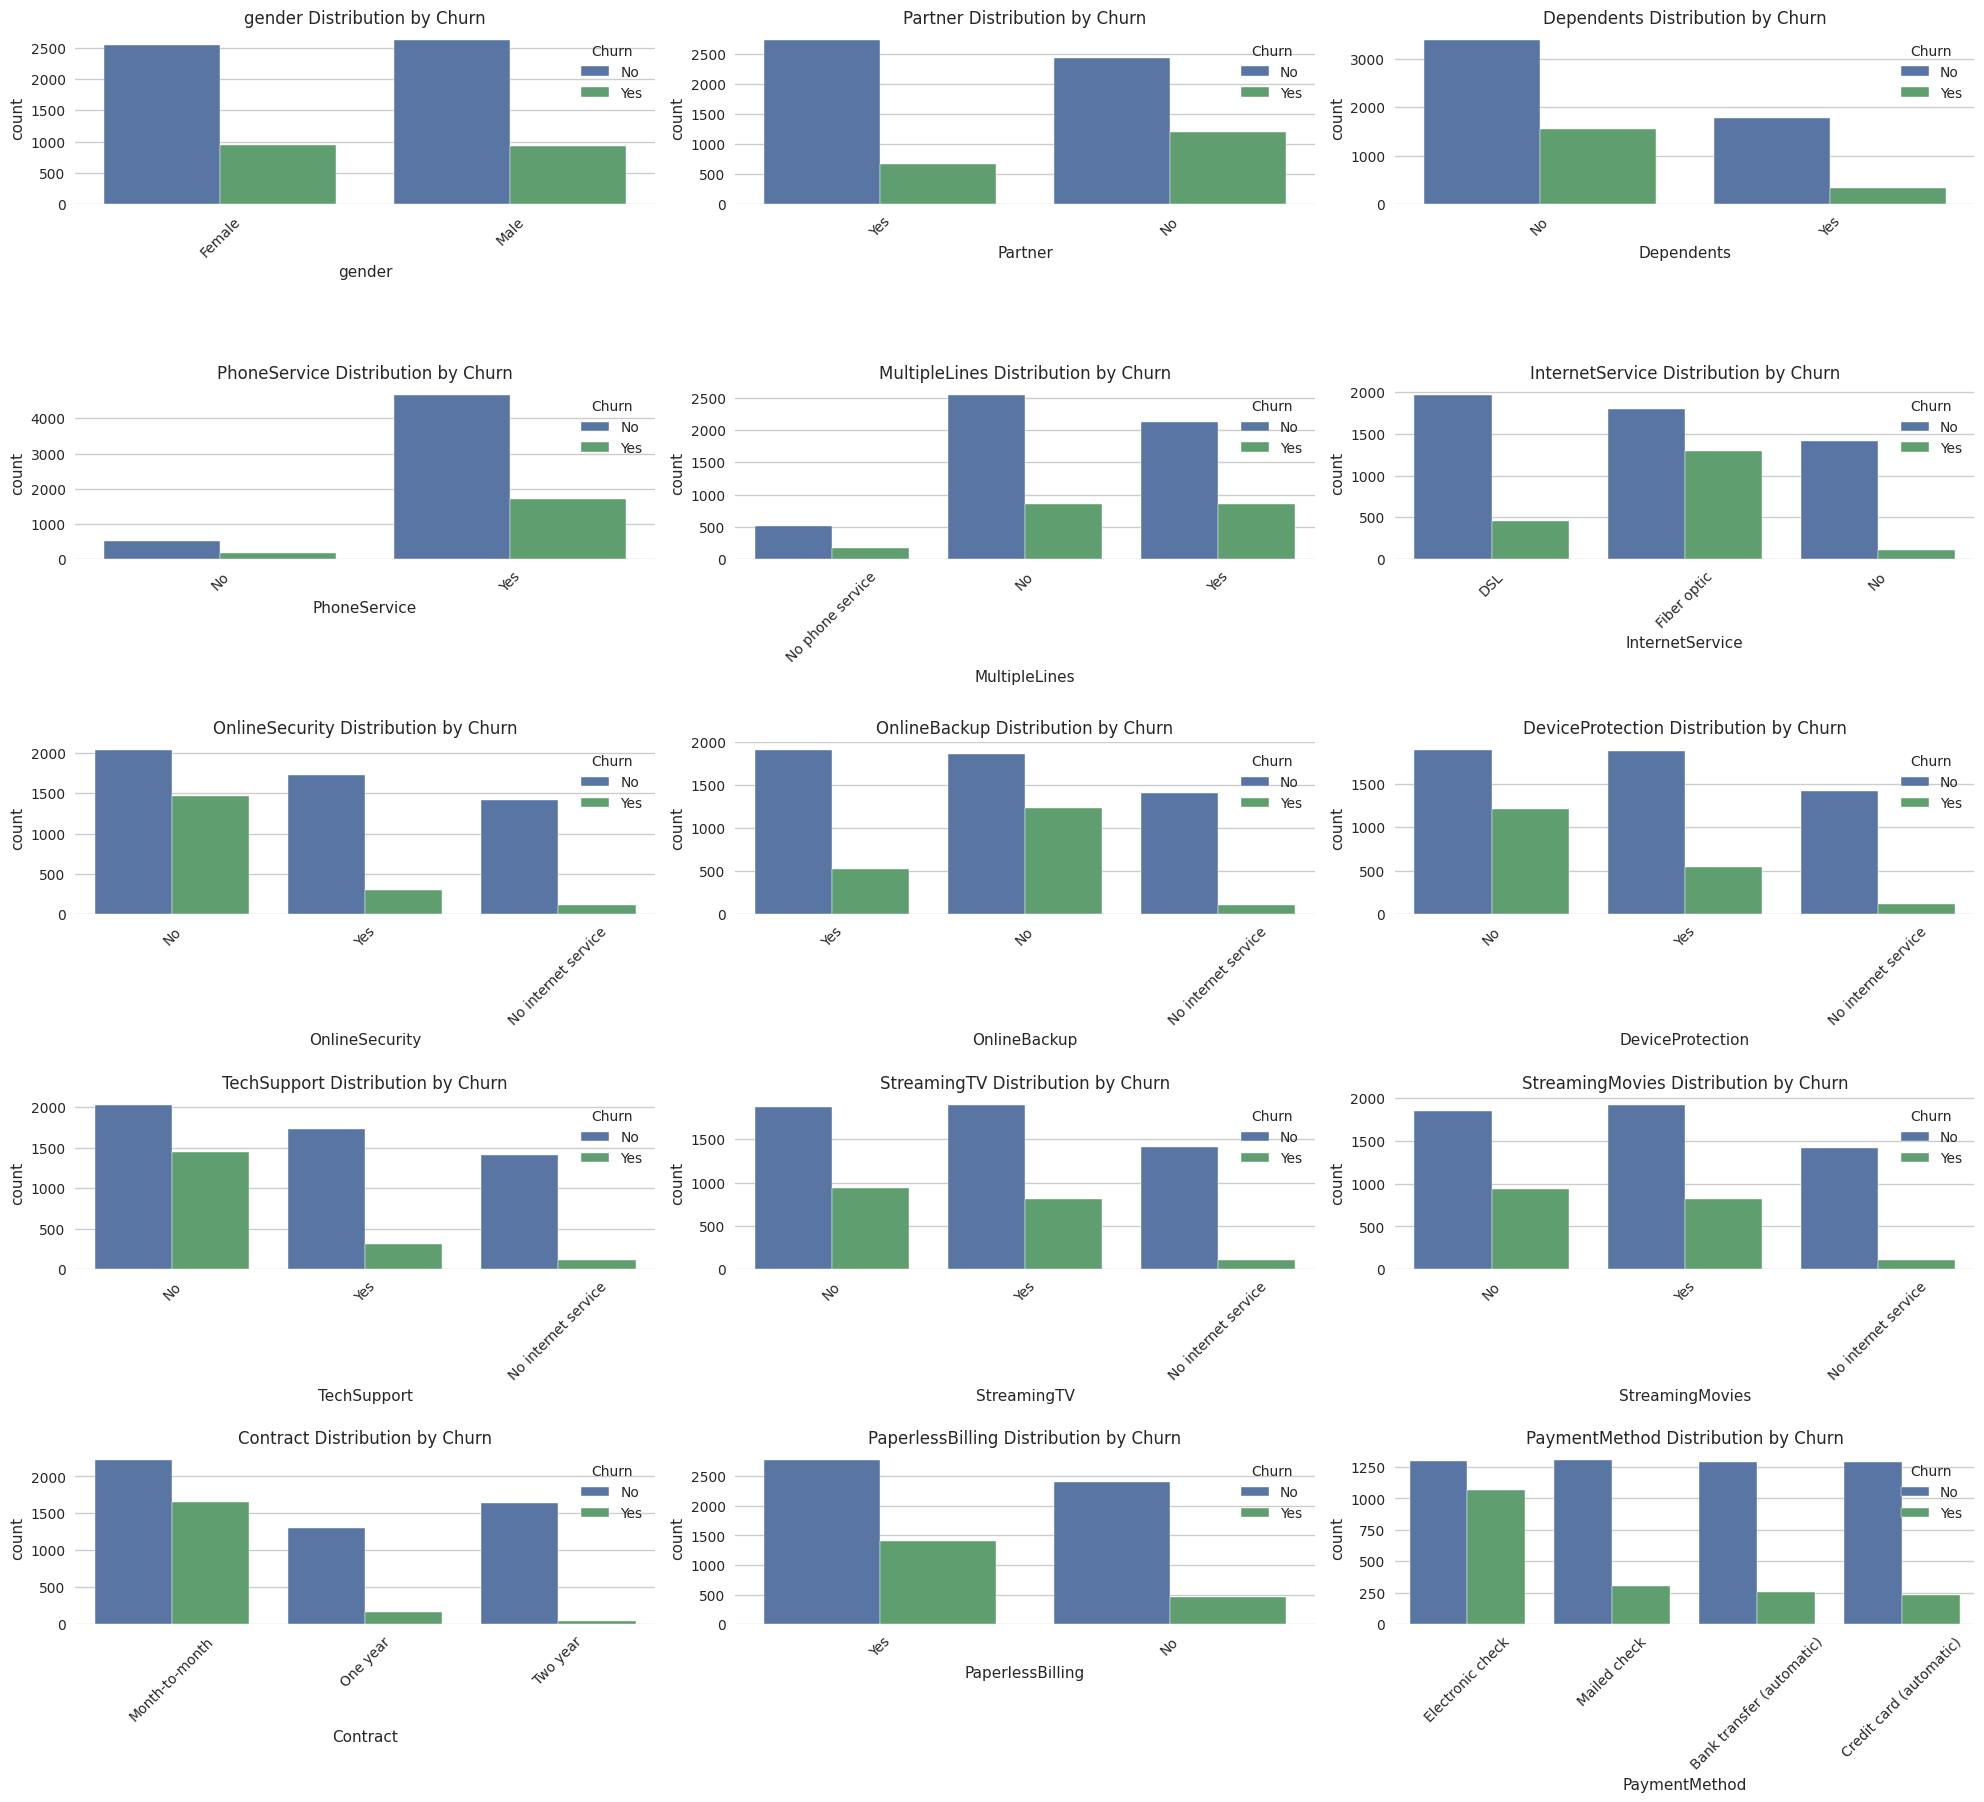

In [12]:
# Basic info
print("Dataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check target distribution
print("\nChurn Distribution:")
print(df['Churn'].value_counts(normalize=True))

# Visualize target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Customer Churn Distribution')
plt.show()

# Analyze numerical features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} vs Churn')
plt.tight_layout()
plt.show()

# Analyze categorical features
cat_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in ['customerID', 'Churn']]

plt.figure(figsize=(20, 20))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(6, 3, i)
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} Distribution by Churn')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Convert TotalCharges to numeric and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Create new features
df['TenureToMonthlyChargeRatio'] = df['tenure'] / (df['MonthlyCharges'] + 1)
df['TotalToMonthlyRatio'] = df['TotalCharges'] / (df['MonthlyCharges'] + 1)
df['HasDependentsAndPartner'] = ((df['Partner'] == 'Yes') & (df['Dependents'] == 'Yes')).astype(int)

# Drop customer ID as it's not useful for prediction
df.drop('customerID', axis=1, inplace=True)

# Define features and target
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing pipelines
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges',
                   'TenureToMonthlyChargeRatio', 'TotalToMonthlyRatio']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [col for col in X.columns if col not in numeric_features]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Add feature selection to pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=20))])


Logistic Regression Performance:
Accuracy: 0.7949
Precision: 0.6375
Recall: 0.5267
F1 Score: 0.5769
ROC AUC: 0.8375
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



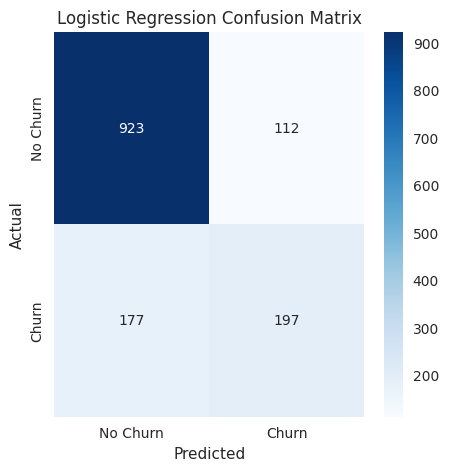


Random Forest Performance:
Accuracy: 0.7814
Precision: 0.6100
Recall: 0.4893
F1 Score: 0.5430
ROC AUC: 0.8080
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



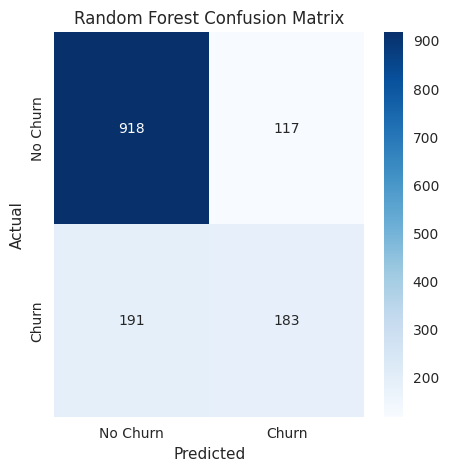


Gradient Boosting Performance:
Accuracy: 0.8027
Precision: 0.6633
Recall: 0.5214
F1 Score: 0.5838
ROC AUC: 0.8437
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



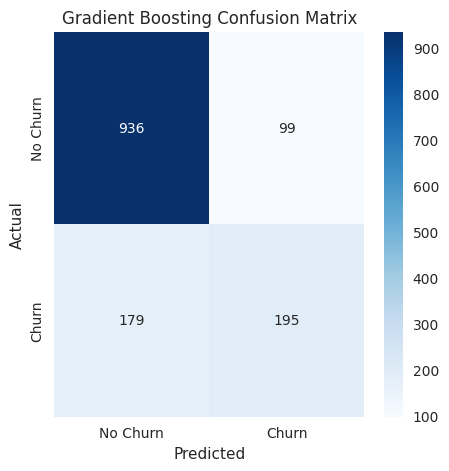


Model Comparison:
                     accuracy  precision    recall        f1   roc_auc
Gradient Boosting    0.802697   0.663265  0.521390  0.583832  0.843657
Logistic Regression  0.794890   0.637540  0.526738  0.576867  0.837451
Random Forest        0.781405   0.610000  0.489305  0.543027  0.808025


In [14]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessing', full_pipeline),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'model': pipeline
    }

    # Print metrics
    print(f"\n{name} Performance:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1 Score: {results[name]['f1']:.4f}")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Compare model performance
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='roc_auc', ascending=False)
print("\nModel Comparison:")
print(results_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']])

In [9]:
# Optimized hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Define reduced parameter distribution
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.05, 0.1],  # Focus on most useful range
    'classifier__max_depth': [3, 5],  # Avoid too deep trees
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Use RandomizedSearchCV with 30 iterations
random_search = RandomizedSearchCV(
    estimator=best_model,
    param_distributions=param_dist,
    n_iter=30,  # Total combinations to try
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Reduced from 5 to 3 folds
    scoring='roc_auc',
    n_jobs=-1,  # Use all cores
    verbose=2,  # More detailed progress
    random_state=42
)

# Fit the model
print("Starting optimized hyperparameter search...")
random_search.fit(X_train, y_train)
print("Hyperparameter search completed!")

# Get best model
best_gb = random_search.best_estimator_

# Evaluate (rest of your existing evaluation code)
y_pred = best_gb.predict(X_test)
y_proba = best_gb.predict_proba(X_test)[:, 1]

print("\nOptimized Gradient Boosting Performance:")
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(best_gb, 'optimized_churn_model.pkl')

Starting optimized hyperparameter search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Hyperparameter search completed!

Optimized Gradient Boosting Performance:
Best Parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05}
Accuracy: 0.8020
Precision: 0.6678
Recall: 0.5053
F1 Score: 0.5753
ROC AUC: 0.8450
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



['optimized_churn_model.pkl']

In [15]:
# Use smaller subset for tuning
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    train_size=0.5,  # Use 50% for tuning
    stratify=y_train,
    random_state=42
)
random_search.fit(X_tune, y_tune)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('preprocessor',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                ['tenure',
                                                                                                 'MonthlyCharges',
                                                                                                 'TotalCharges',
                                                                                                 'TenureToMonthlyChargeRa...
                                                               SelectKBest(k=20))])),
                                             ('classifier',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.05,
                                                                      0.1],
                                        'classifier__max_depth': [3, 5],
                                        'classifier__min_samples_leaf': [1, 2],
                                        'classifier__min_samples_split': [2, 5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [16]:
# During tuning, use simpler metric
random_search.scoring = 'f1'  # Faster than roc_auc

In [17]:
# Set n_jobs to number of physical cores
import os
n_cores = os.cpu_count()
random_search.n_jobs = n_cores // 2  # Leave some cores free

In [19]:
# Optimized hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Define reduced parameter distribution
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.05, 0.1],  # Focus on most useful range
    'classifier__max_depth': [3, 5],  # Avoid too deep trees
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Use RandomizedSearchCV with 30 iterations
random_search = RandomizedSearchCV(
    estimator=best_model,
    param_distributions=param_dist,
    n_iter=30,  # Total combinations to try
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Reduced from 5 to 3 folds
    scoring='roc_auc',
    n_jobs=-1,  # Use all cores
    verbose=2,  # More detailed progress
    random_state=42
)

# Fit the model
print("Starting optimized hyperparameter search...")
random_search.fit(X_train, y_train)
print("Hyperparameter search completed!")

# Get best model
best_gb = random_search.best_estimator_

# Evaluate (rest of your existing evaluation code)
y_pred = best_gb.predict(X_test)
y_proba = best_gb.predict_proba(X_test)[:, 1]

print("\nOptimized Gradient Boosting Performance:")
print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(best_gb, 'optimized_churn_model.pkl')

Starting optimized hyperparameter search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Hyperparameter search completed!

Optimized Gradient Boosting Performance:
Best Parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05}
Accuracy: 0.8020
Precision: 0.6678
Recall: 0.5053
F1 Score: 0.5753
ROC AUC: 0.8450
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



['optimized_churn_model.pkl']

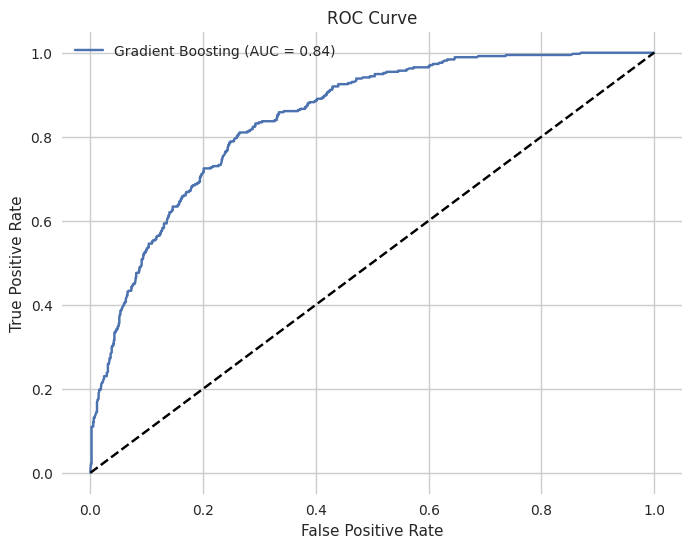

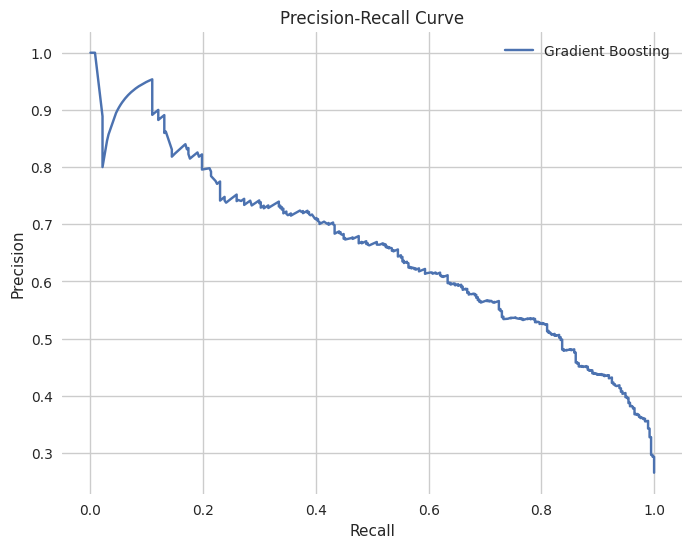

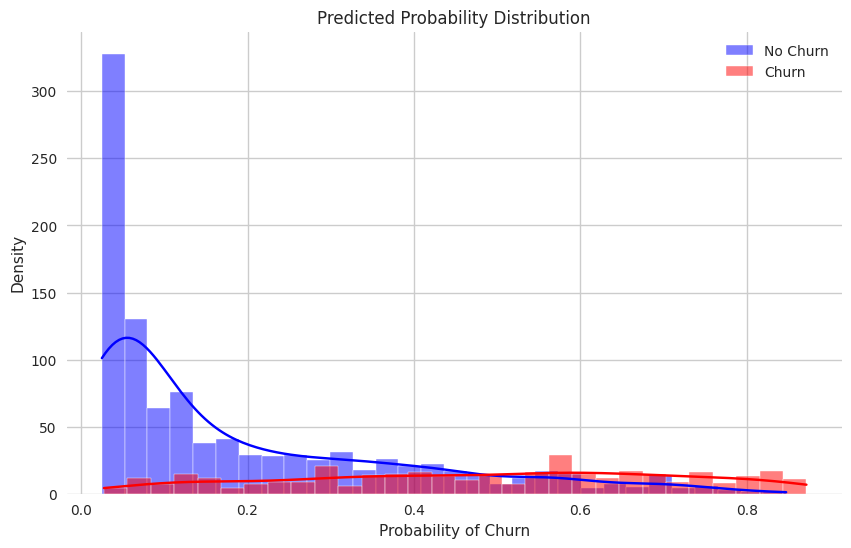

In [20]:
# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label='Gradient Boosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Probability Distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_proba[y_test == 0], bins=30, kde=True, color='blue', label='No Churn')
sns.histplot(y_proba[y_test == 1], bins=30, kde=True, color='red', label='Churn')
plt.title('Predicted Probability Distribution')
plt.xlabel('Probability of Churn')
plt.ylabel('Density')
plt.legend()
plt.show()

<Figure size 800x550 with 0 Axes>

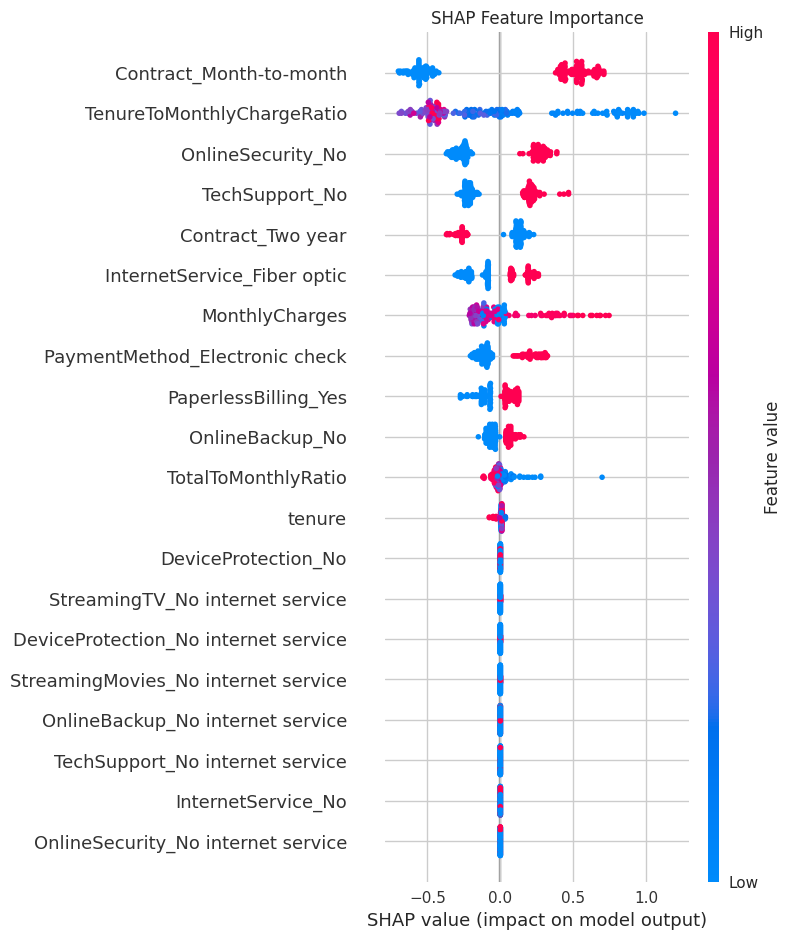

<Figure size 800x550 with 0 Axes>

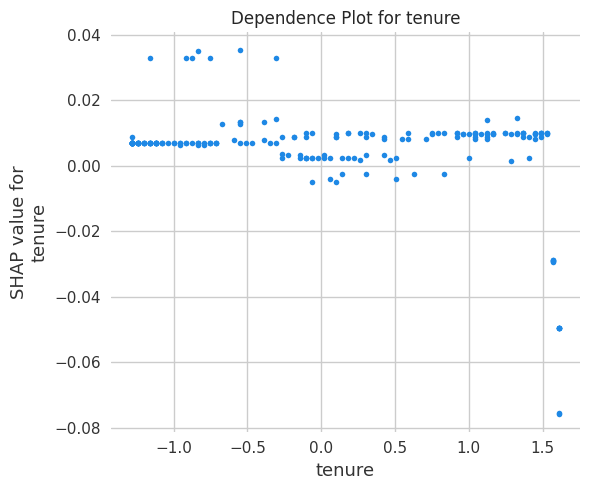

<Figure size 800x550 with 0 Axes>

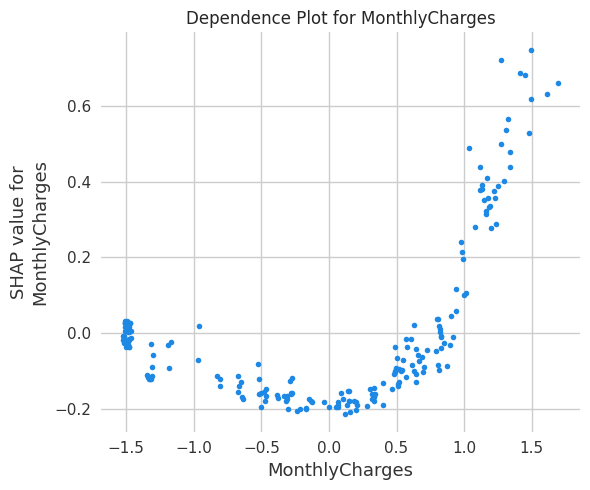

<Figure size 800x550 with 0 Axes>

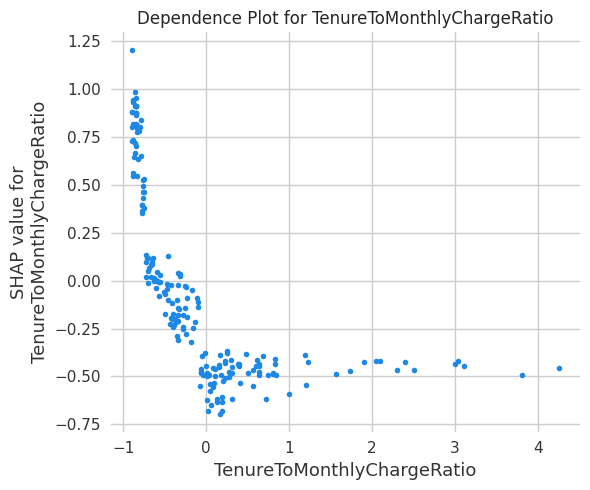

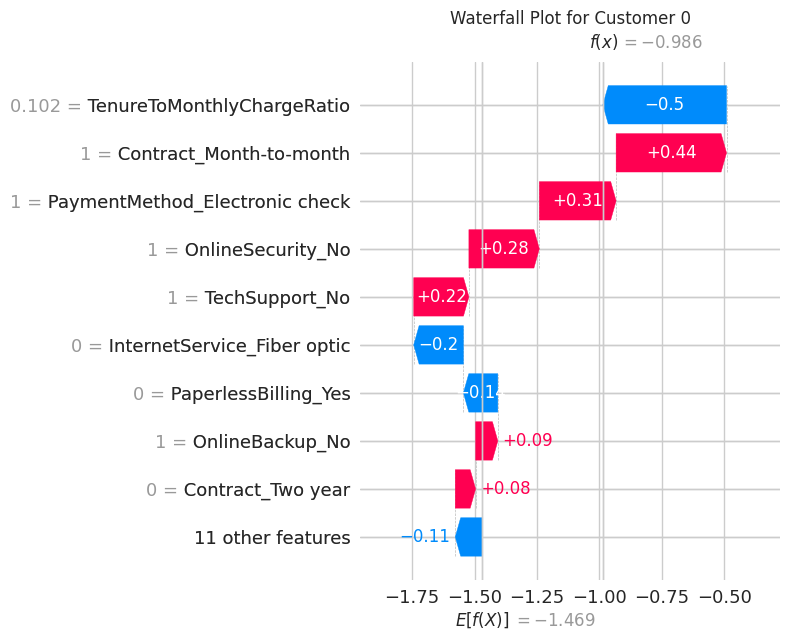

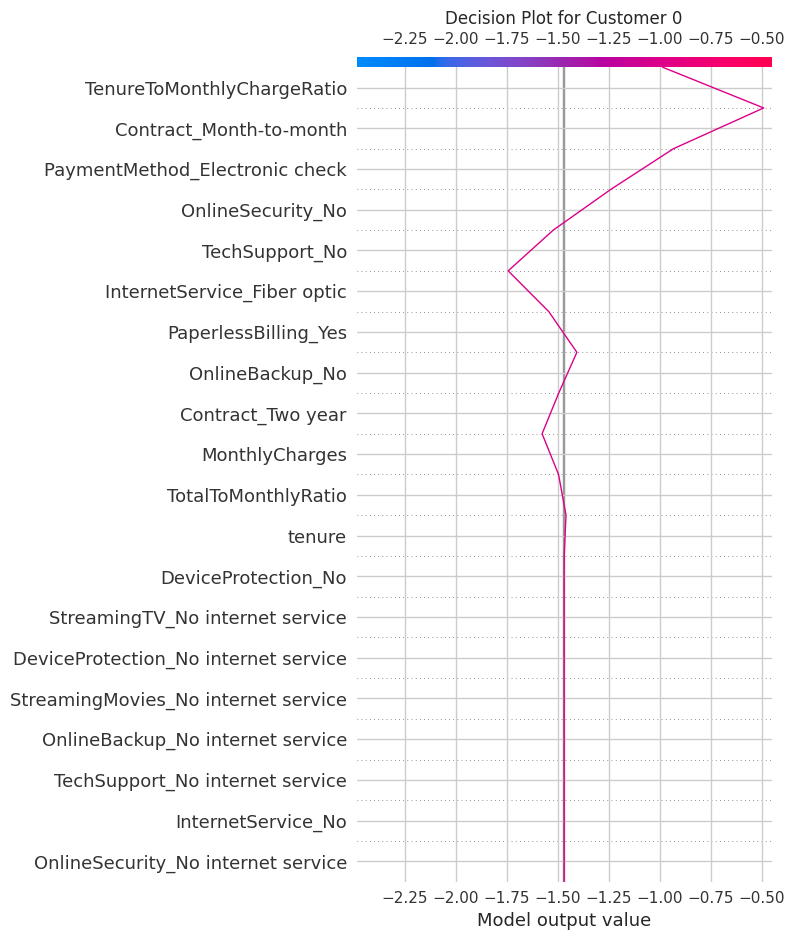

In [28]:
# 1. Get SHAP values with robust expected value handling
explainer = shap.TreeExplainer(classifier)
sample_size = min(200, len(X_train))
X_sample = preprocessed_data[:sample_size]

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Handle all possible expected_value formats
if isinstance(explainer.expected_value, np.ndarray):
    if len(explainer.expected_value) == 1:
        expected_value = float(explainer.expected_value[0])
    else:
        # For multi-class, use the positive class (Churn="Yes")
        expected_value = float(explainer.expected_value[1])
else:
    # Single scalar value
    expected_value = float(explainer.expected_value)

# Handle all possible shap_values formats
if isinstance(shap_values, list):
    # For binary classification with TreeExplainer, shap_values[1] is for positive class
    shap_values = shap_values[1]
elif len(shap_values.shape) == 3:
    # For multi-output models
    shap_values = shap_values[..., 1]  # Get values for positive class

# Ensure consistent 2D array
shap_values = np.array(shap_values)
if len(shap_values.shape) == 1:
    shap_values = shap_values.reshape(1, -1)

# 2. Create Visualizations

# Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=selected_feature_names, max_display=20, show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# Force Plot (JavaScript version works better)
shap.initjs()
display(shap.force_plot(
    expected_value,
    shap_values[sample_idx],
    X_sample[sample_idx],
    feature_names=selected_feature_names
))

# Dependence Plots
for i, feature_name in enumerate(selected_feature_names[:3]):
    try:
        feature_idx = selected_feature_names.index(feature_name)
        plt.figure()
        shap.dependence_plot(
            feature_idx,
            shap_values,
            X_sample,
            feature_names=selected_feature_names,
            interaction_index=None,
            show=False
        )
        plt.title(f'Dependence Plot for {feature_name}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create dependence plot for {feature_name}: {str(e)}")

# Waterfall Plot (using most stable method)
try:
    plt.figure()
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[sample_idx],
            base_values=expected_value,
            data=X_sample[sample_idx],
            feature_names=selected_feature_names
        ),
        max_display=10,
        show=False
    )
    plt.title(f'Waterfall Plot for Customer {sample_idx}')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create waterfall plot: {str(e)}")
    # Fallback to simple bar plot
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(shap_values[sample_idx])
    plt.barh(range(10), shap_values[sample_idx][sorted_idx[-10:]])
    plt.yticks(range(10), np.array(selected_feature_names)[sorted_idx[-10:]])
    plt.title(f'Top Features for Customer {sample_idx}')
    plt.show()

# Decision Plot
try:
    plt.figure()
    shap.decision_plot(
        expected_value,
        shap_values[sample_idx:sample_idx+1],
        feature_names=selected_feature_names,
        ignore_warnings=True,
        show=False
    )
    plt.title(f'Decision Plot for Customer {sample_idx}')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create decision plot: {str(e)}")